In [1]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Dropout
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd

from functions.rename_split import copy_and_rename_files, filter_files
from functions.load_data import collect_data, load_data
from functions.normalize import normalize_images
from functions.plot_images import plot_images

ModuleNotFoundError: No module named 'functions.rename_split'

In [ ]:
# Define paths
source_dir = "data/raw/"
splits_dir = "data/proc/"
train_dir = "data/proc/train/"
test_dir = "data/proc/test/"
val_dir = "data/proc/val/"

# Create train, test, and val directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

## Splitting data in 3 parts (train, test and val)

In [ ]:
# Initialize global counter
global_counter = 1

# Loop through 'yes' and 'no' folders
for category in ['yes', 'no']:
    category_dir = os.path.join(source_dir, category)
    # Get list of image files
    files = os.listdir(category_dir)
    # Filter out files ending with 'Zone.Identifier'
    files = filter_files(files)
    # Split files into train, test, and val sets
    train_files, test_val_files = train_test_split(files, test_size=0.3, random_state=42) # 60% train
    test_files, val_files = train_test_split(test_val_files, test_size=0.5, random_state=42) # 20% test, 20% val
    # Create category directories in train, test, and val directories if they don't exist
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    # Copy and rename files to respective directories
    global_counter = copy_and_rename_files(category_dir, os.path.join(train_dir, category), train_files, "img_", global_counter)
    global_counter = copy_and_rename_files(category_dir, os.path.join(test_dir, category), test_files, "img_", global_counter)
    global_counter = copy_and_rename_files(category_dir, os.path.join(val_dir, category), val_files, "img_", global_counter)

print("Images have been copied and renamed in train, test, and val sets successfully.")

Images have been copied and renamed in train, test, and val sets successfully.


## Creating a dataframe from data

In [ ]:
splits = ['train', 'test', 'val']

data = []

for split in splits:
    for tumor_type in ['no', 'yes']:
        data += collect_data(os.path.join(splits_dir, split, tumor_type), tumor_type, split)

df = pd.DataFrame(data)

In [ ]:
df

,img_path,tumor,dataset
0,img/splits/train/no/img_00163.jpg,0,train
1,img/splits/train/no/img_00171.jpg,0,train
2,img/splits/train/no/img_00172.jpg,0,train
3,img/splits/train/no/img_00179.jpg,0,train
4,img/splits/train/no/img_00205.jpg,0,train
...,...,...,...
248,img/splits/val/yes/img_00152.jpg,1,val
249,img/splits/val/yes/img_00147.jpg,1,val
250,img/splits/val/yes/img_00141.jpg,1,val
251,img/splits/val/yes/img_00146.jpg,1,val


## Loading and splitting data in train, test and val

In [ ]:
X_train, y_train, labels = load_data(train_dir)
X_test, y_test, _ = load_data(test_dir)
X_val, y_val, _ = load_data(val_dir)

176 images loaded from img/splits/train/ directory.
38 images loaded from img/splits/test/ directory.
39 images loaded from img/splits/val/ directory.


## Normalizing data for better model fitting

In [ ]:
X_train_norm = normalize_images(X_train, target_size=(224, 224), apply_sharpening=True, apply_sobel=False)
X_test_norm = normalize_images(X_test, target_size=(224, 224), apply_sharpening=True, apply_sobel=False)
X_val_norm = normalize_images(X_val, target_size=(224, 224), apply_sharpening=True, apply_sobel=False)

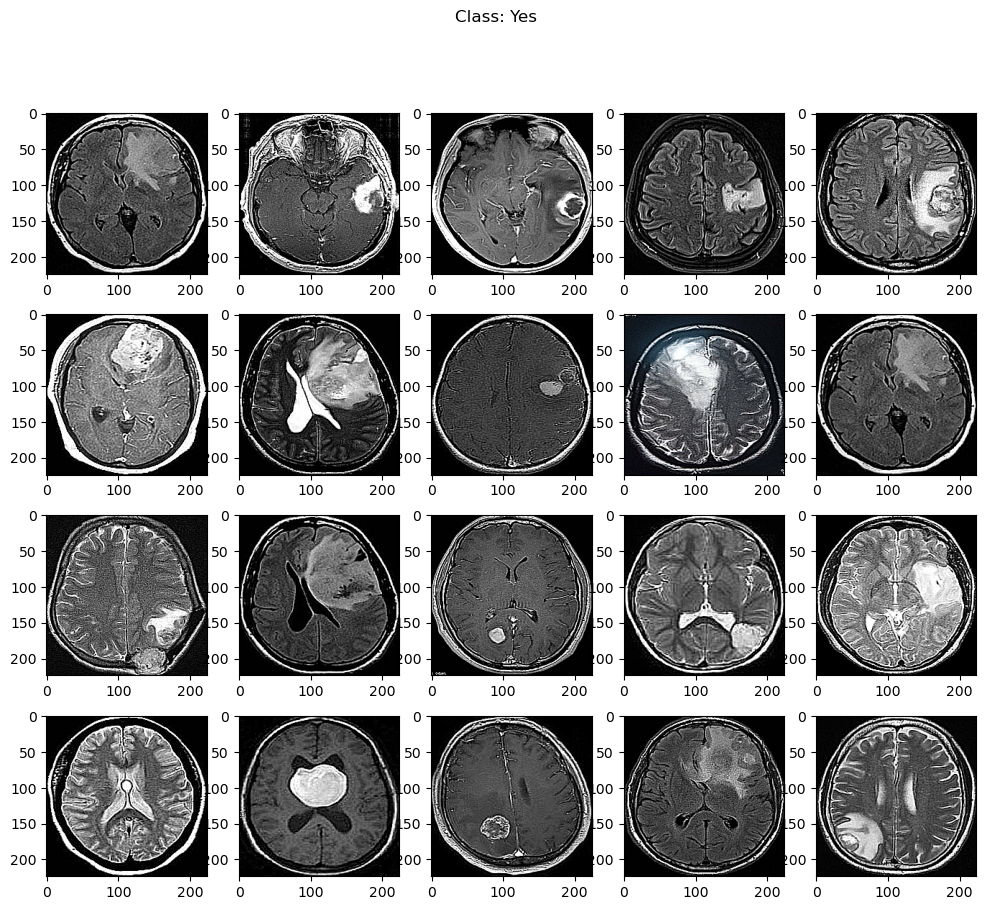

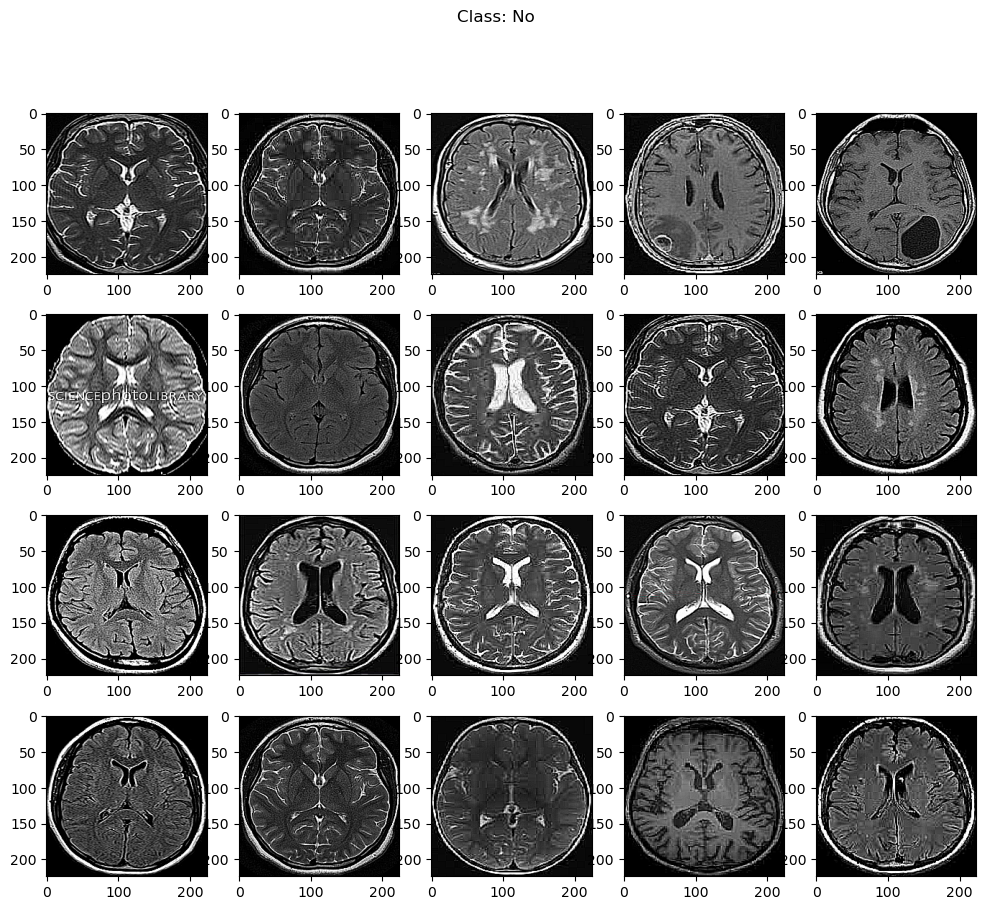

In [ ]:
plot_images(X_train_norm, y_train, 20)

## Model connection with MLFLOW

In [ ]:
import mlflow
# don't forget to run MLFLOW before : mlflow server --host 127.0.0.1 --port 5000

In [ ]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
mlflow.set_experiment("tumor_detection")
mlflow.tensorflow.autolog()

## Model training and plotting results

In [ ]:
# Créer un modèle VGG-16 pré-entraîné (ne pas inclure la couche dense finale)
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))

NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='sigmoid'))

# figer les poids du VGG
model.layers[0].trainable = False

# Compiler le modèle
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

# Afficher la structure du modèle
model.summary()

# Créer un générateur d'images pour la data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

# Ajuster le générateur aux données d'entraînement
datagen.fit(X_train_norm)

# Entraîner le modèle avec l'augmentation de données
history = model.fit(datagen.flow(X_train_norm, y_train, batch_size=32),
          epochs=10,
          steps_per_epoch=len(X_train_norm) // 32,
          validation_data=(X_val_norm, y_val))

2024-02-26 15:37:36.565611: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-26 15:37:36.566096: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14739777 (56.23 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


2024/02/26 15:37:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1e4a678c7e194010b872e594b1e8b8b0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2024/02/26 15:37:37 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.preprocessing.image.NumpyArrayIterator'>. Dataset logging skipped.


Epoch 1/10
5/5 [==============================] - 16s 3s/step - loss: 1.5900 - accuracy: 0.5625 - val_loss: 4.7246 - val_accuracy: 0.6667
Epoch 2/10
5/5 [==============================] - 18s 4s/step - loss: 1.0086 - accuracy: 0.5625 - val_loss: 7.8400 - val_accuracy: 0.6923
Epoch 3/10
5/5 [==============================] - 18s 4s/step - loss: 0.7379 - accuracy: 0.6938 - val_loss: 3.7404 - val_accuracy: 0.7436
Epoch 4/10
5/5 [==============================] - 17s 3s/step - loss: 0.7470 - accuracy: 0.6389 - val_loss: 13.7657 - val_accuracy: 0.4872
Epoch 5/10
5/5 [==============================] - 18s 4s/step - loss: 0.8321 - accuracy: 0.6528 - val_loss: 3.9458 - val_accuracy: 0.7949
Epoch 6/10
5/5 [==============================] - 17s 3s/step - loss: 0.8618 - accuracy: 0.6181 - val_loss: 3.3961 - val_accuracy: 0.8205
Epoch 7/10
5/5 [==============================] - 18s 4s/step - loss: 0.5369 - accuracy: 0.7222 - val_loss: 4.8125 - val_accuracy: 0.7949
Epoch 8/10
5/5 [=================

2024/02/26 15:40:28 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2024/02/26 15:40:28 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpmn_wqt53/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpmn_wqt53/model/data/model/assets
2024/02/26 15:40:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/lucie/miniconda3/envs/cv_env/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [ ]:
model.evaluate(X_test_norm, y_test)

2/2 [==============================] - 3s 454ms/step - loss: 9.6310 - accuracy: 0.6842


[9.630995750427246, 0.6842105388641357]

In [ ]:
def plot_metrics(history):
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

# Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

# Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

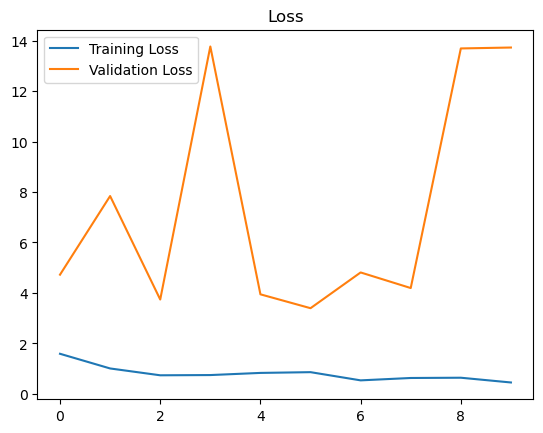

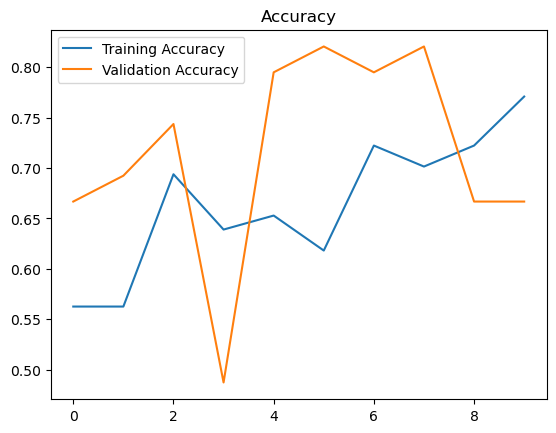

In [ ]:
plot_metrics(history.history)